# Stock price predictor

## Import necessary packages

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

## Read in stock data

Data can be found [here](https://data-flair.training/blogs/download-tata-global-beverages-stocks-data/). 

In [19]:
df=pd.read_csv("./data/NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [20]:
df.shape

(1235, 8)

## Plot data to see the movement of the stock price 

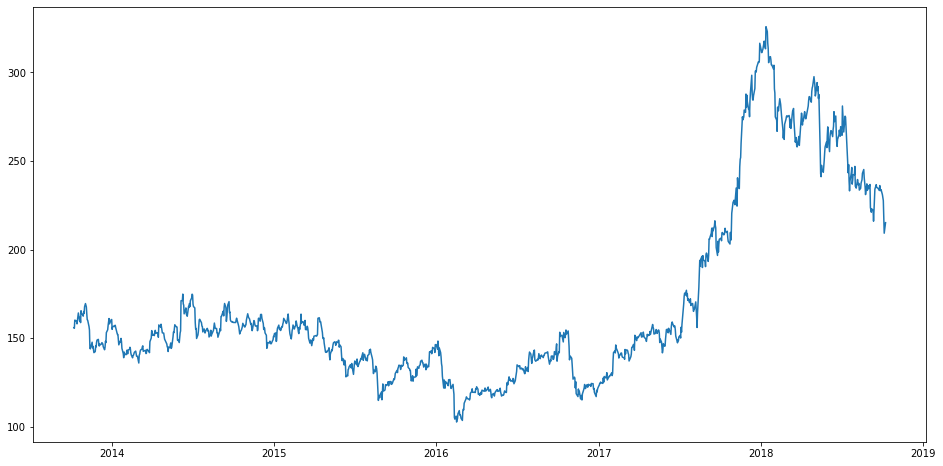

In [21]:
df["Date"] = pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"], label = 'Close Price History')

## Sort data according to date and closing price

In [22]:
data = df.sort_index(ascending=True, axis=0)
# Create a new dataset
new_dataset = pd.DataFrame(index=range(0,len(df)), columns=['Date','Close'])
# Transfer corresponding values from old database to new database
for i in range(0,len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close"][i] = data['Close'][i]

In [23]:
# Reset the index to Date and drop the Date column
new_dataset.index = new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [24]:
new_dataset

,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45
...,...
2018-10-01,230.9
2018-10-03,227.6
2018-10-04,218.2


## Create an array of the stock prices

In [75]:
# Scaling the data in feature range (0,1)
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset = new_dataset.values

In [76]:
final_dataset

array([[155.8],
       [155.55],
       [160.15],
       ...,
       [218.2],
       [209.2],
       [215.15]], dtype=object)

## Normalize data

In [69]:
# Separate data into training and validation
train_data = final_dataset[0:987,:]
valid_data = final_dataset[987:,:]

# Use MinMaxScaler to normalize features
scaler=MinMaxScaler(feature_range=(0,1))
# Fit transform final_dataset using MinMaxScaler
scaled_data = scaler.fit_transform(final_dataset)

# Create lists for x and y training data
x_train_data, y_train_data = [],[]

# append scaled data to the training lists
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

# transforms lists to arrays
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# reshape x_train data
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1],1))

## Initialize the LSTM model

In [70]:
# Initialize LSTM model
lstm_model = Sequential()
# Using 50 LSTM units to allow for more long sequences
lstm_model.add(LSTM(units=50,return_sequences=True, input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
# Create inputs data for model by subtracting valid data and another 60 values
inputs_data = new_dataset[len(new_dataset) - len(valid_data)-60:].values
# Reshaping input data
inputs_data = inputs_data.reshape(-1,1)
# Scaling input data
inputs_data = scaler.transform(inputs_data)
# Compile model using mean_squared_error as the lost and Adam optimizer
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
# Fit the model on the training data
lstm_model.fit(x_train_data,y_train_data, epochs=1, batch_size=1, verbose=2)

927/927 - 8s - loss: 0.0011 - 8s/epoch - 9ms/step


## Creating a test set

In [72]:
# Creating a list for X_test based on the inputs_data
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])

X_test = np.array(X_test)
# Creating a predicted closing price
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [73]:
lstm_model.save("saved_model.h5")

/var/folders/6w/3d34pjd946x3b0pm_22jj5wr0000gn/T/ipykernel_16365/717735034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


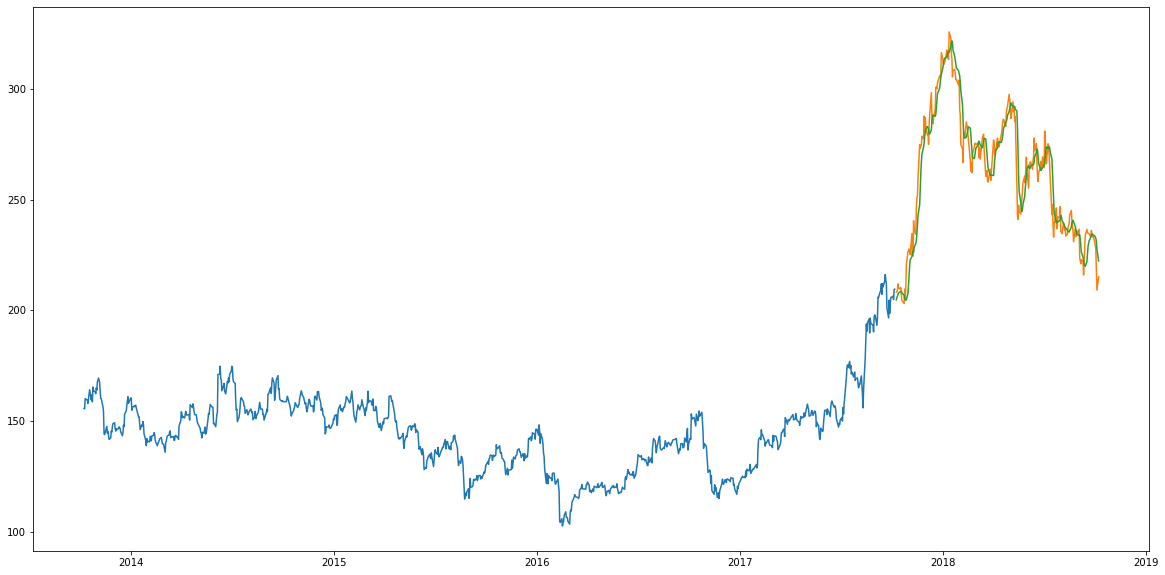

In [74]:
# Plotting the training, validation and predicted data to see how the model did
train_data = new_dataset[:987]
valid_data = new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close', "Predictions"]])

All in all the model preformed impressively, almost mirroring the actual closing prices exactly. 